Integrantes del equipo:
- Alonso Cañas Rico
- Hugo Jiménez García

# Parameters

In [1]:
EPOCHS = 20
LEARNING_RATE = 3e-5
BATCH_SIZE = 128
LAYERS_TO_TRAIN = 1

In [2]:
ai_generated_path = "pan24-generative-authorship-news/machines"
human_path = "pan24-generative-authorship-news/human.jsonl"

# Initial config

## Libraries

In [3]:
import os
import json
import pandas as pd
import warnings
import logging
import torch
from torch.utils.data import DataLoader

c:\Users\Hugo\git\NLP\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Device

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
warnings.filterwarnings("ignore", message=".*overflowing tokens.*")
logging.disable(logging.WARNING)

# Data

## Import data

In [6]:
model, id, text = [], [], []

# Loop through every file in the directory
for filename in os.listdir(ai_generated_path):
    # Check if the file is a JSONL file
    if filename.endswith('.jsonl'):
        filepath = os.path.join(ai_generated_path, filename)
        with open(filepath, 'r', encoding='utf-8') as jsonl_file:
            for line in jsonl_file:
                # Each line is a separate JSON object
                data = json.loads(line)
                model.append(filename)
                id.append(data['id'])
                text.append(data['text'])

df_generated = pd.DataFrame({'model': model, 'id': id, 'text': text, 'ai_generated': 1})
df_generated

,model,id,text,ai_generated
0,alpaca-7b.jsonl,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...,Inaugural Address: President Joseph R. Biden J...,1
1,alpaca-7b.jsonl,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...,Setting the Record Straight: Fact-Checking the...,1
2,alpaca-7b.jsonl,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...,Joe Biden Takes the Oath of Office as 46th Pre...,1
3,alpaca-7b.jsonl,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...,Joe Biden Takes Oath as 46th President of Unit...,1
4,alpaca-7b.jsonl,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...,Amanda Gorman's Inspiring Poem Celebrates Hope...,1
...,...,...,...,...
14126,vicgalle-gpt2-open-instruct-v1.jsonl,vicgalle-gpt2-open-instruct-v1/news-2021-01-01...,'The Disappearance of Gabby Petito' – A Compre...,1
14127,vicgalle-gpt2-open-instruct-v1.jsonl,vicgalle-gpt2-open-instruct-v1/news-2021-01-01...,"Utah State Police Search for Gabby Petito, Tra...",1
14128,vicgalle-gpt2-open-instruct-v1.jsonl,vicgalle-gpt2-open-instruct-v1/news-2021-01-01...,McKenna's Lost Friend: Debunking the Evidence ...,1
14129,vicgalle-gpt2-open-instruct-v1.jsonl,vicgalle-gpt2-open-instruct-v1/news-2021-01-01...,"""Gunshots Found in Florida Nature Preserve: A ...",1


In [7]:
id, text = [], []

with open(human_path, 'r', encoding='utf-8') as jsonl_file:
    for line in jsonl_file:
        # Each line is a separate JSON object
        data = json.loads(line)
        id.append(data['id'])
        text.append(data['text'])

df_human = pd.DataFrame({'model': 'Human', 'id': id, 'text': text, 'ai_generated': 0})
df_human

,model,id,text,ai_generated
0,Human,articles-cleaned-truncated/news-2021-01-01-202...,Inaugural Address by President Joseph R. Biden...,0
1,Human,articles-cleaned-truncated/news-2021-01-01-202...,Fact check: Biden inauguration impacted by pan...,0
2,Human,articles-cleaned-truncated/news-2021-01-01-202...,Highlights from Joe Biden's 2021 inauguration\...,0
3,Human,articles-cleaned-truncated/news-2021-01-01-202...,"Biden takes the helm, appeals for unity to tak...",0
4,Human,articles-cleaned-truncated/news-2021-01-01-202...,'The Hill We Climb': Read Amanda Gorman's inau...,0
...,...,...,...,...
1082,Human,articles-cleaned-truncated/news-2021-01-01-202...,How amateur detectives on social media helped ...,0
1083,Human,articles-cleaned-truncated/news-2021-01-01-202...,Authorities searching for missing 22-year-old ...,0
1084,Human,articles-cleaned-truncated/news-2021-01-01-202...,Univ. of Wisconsin Oshkosh student helping Gab...,0
1085,Human,articles-cleaned-truncated/news-2021-01-01-202...,Did the Internet Actually Help Find Gabby Peti...,0


In [8]:
df = pd.concat([df_generated, df_human])[['text', 'ai_generated', 'id']]
df

,text,ai_generated,id
0,Inaugural Address: President Joseph R. Biden J...,1,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...
1,Setting the Record Straight: Fact-Checking the...,1,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...
2,Joe Biden Takes the Oath of Office as 46th Pre...,1,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...
3,Joe Biden Takes Oath as 46th President of Unit...,1,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...
4,Amanda Gorman's Inspiring Poem Celebrates Hope...,1,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...
...,...,...,...
1082,How amateur detectives on social media helped ...,0,articles-cleaned-truncated/news-2021-01-01-202...
1083,Authorities searching for missing 22-year-old ...,0,articles-cleaned-truncated/news-2021-01-01-202...
1084,Univ. of Wisconsin Oshkosh student helping Gab...,0,articles-cleaned-truncated/news-2021-01-01-202...
1085,Did the Internet Actually Help Find Gabby Peti...,0,articles-cleaned-truncated/news-2021-01-01-202...


## Process Data - Todas las posibles combinaciones

In [9]:
# from sklearn.model_selection import train_test_split
# import pandas as pd

# test_size = 0.25
# val_size = 0.125
# _adjusted_val_size = val_size / (1 - test_size)

# # Extraer el segundo y tercer segmento de los IDs
# df['base_id'] = df['id'].apply(lambda x: '/'.join(x.split('/')[1:]))  # Coger los ids sin la parte que identifica al autor del fragmento de texto.

# # Paso 1: Dividir los datos según los `base_id`
# base_ids = df['base_id'].unique()
# train_base_ids, test_base_ids = train_test_split(base_ids, test_size=test_size, random_state=1337)
# train_base_ids, val_base_ids = train_test_split(train_base_ids, test_size=_adjusted_val_size, random_state=1337) 

# # Crear DataFrames por conjunto
# train = df[df['base_id'].isin(train_base_ids)]
# val = df[df['base_id'].isin(val_base_ids)]
# test = df[df['base_id'].isin(test_base_ids)]

# train.reset_index(drop=True, inplace=True)
# val.reset_index(drop=True, inplace=True)
# test.reset_index(drop=True, inplace=True)

# print(f"train shape: {train.shape}")
# print(f"val shape: {val.shape}")
# print(f"test shape: {test.shape}")

In [10]:
# # Función para generar combinaciones humano-IA dentro de un DataFrame
# def create_combinations(df):
#     # Filtrar textos humanos e IA
#     df_human = df[df['ai_generated'] == 0][['text']].reset_index(drop=True)
#     df_ia = df[df['ai_generated'] == 1][['text']].reset_index(drop=True)
    
#     # Producto cartesiano para todas las combinaciones posibles
#     cartesian_df = df_human.merge(df_ia, how='cross', suffixes=('_human', '_ia'))
#     cartesian_df = cartesian_df.sample(frac=1).reset_index(drop=True)

#     # Número total de combinaciones
#     total_combinations = len(cartesian_df)

#     # Primera mitad: humano en comment_text_1, IA en comment_text_2
#     half_1 = cartesian_df.iloc[:total_combinations // 2].copy()
#     half_1['comment_text_1'] = half_1['text_human']
#     half_1['comment_text_2'] = half_1['text_ia']
#     half_1['list'] = 0  # Etiqueta 0 para esta disposición

#     # Segunda mitad: IA en comment_text_1, humano en comment_text_2
#     half_2 = cartesian_df.iloc[total_combinations // 2:].copy()
#     half_2['comment_text_1'] = half_2['text_ia']
#     half_2['comment_text_2'] = half_2['text_human']
#     half_2['list'] = 1  # Etiqueta 1 para esta disposición
    
#     # Combinar, reorganizar y limpiar
#     balanced_df = pd.concat([half_1, half_2], ignore_index=True)
#     balanced_df = balanced_df.drop(columns=['text_human', 'text_ia']).sample(frac=1).reset_index(drop=True)
    
#     return balanced_df


In [11]:
# # Paso 2: Generar combinaciones para cada conjunto
# train = create_combinations(train)
# val = create_combinations(val)
# test = create_combinations(test)

In [12]:
# # Print the dimensions
# print(f"train shape: {train.shape} / Text on comment_text_1 is human-generated: {train['list'].value_counts()[0]} - Text on comment_text_2 is human-generated: {train['list'].value_counts()[1]}")
# print(f"val shape: {val.shape} / Text on comment_text_1 is human-generated: {val['list'].value_counts()[0]} - Text on comment_text_2 is human-generated: {val['list'].value_counts()[1]}")
# print(f"test shape: {test.shape} / Text on comment_text_1 is human-generated: {test['list'].value_counts()[0]} - Text on comment_text_2 is human-generated: {test['list'].value_counts()[1]}")

## Process Data - Combinaciones únicamente del mismo id

In [13]:
from sklearn.model_selection import train_test_split
import pandas as pd

test_size = 0.25
val_size = 0.125
_adjusted_val_size = val_size / (1 - test_size)

# Extraer el segundo y tercer segmento de los IDs
df['base_id'] = df['id'].apply(lambda x: '/'.join(x.split('/')[1:]))  # Coger los ids sin la parte que identifica al autor del fragmento de texto.

# Paso 1: Dividir los datos según los `base_id`
base_ids = df['base_id'].unique()
train_base_ids, test_base_ids = train_test_split(base_ids, test_size=test_size, random_state=1337)
train_base_ids, val_base_ids = train_test_split(train_base_ids, test_size=_adjusted_val_size, random_state=1337) 

# Crear DataFrames por conjunto
train = df[df['base_id'].isin(train_base_ids)]
val = df[df['base_id'].isin(val_base_ids)]
test = df[df['base_id'].isin(test_base_ids)]

train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

print(f"train shape: {train.shape}")
print(f"val shape: {val.shape}")
print(f"test shape: {test.shape}")

train shape: (9506, 4)
val shape: (1904, 4)
test shape: (3808, 4)


In [14]:
def create_combinations_within_id(df):
    # Lista para almacenar las combinaciones de cada `base_id`
    combinations = []
    
    # Iterar sobre cada `base_id`
    for base_id, group in df.groupby('base_id'):
        # Filtrar textos humanos e IA dentro del grupo
        df_human = group[group['ai_generated'] == 0][['text']].reset_index(drop=True)
        df_ia = group[group['ai_generated'] == 1][['text']].reset_index(drop=True)
        
        # Producto cartesiano dentro del `base_id`
        cartesian_df = df_human.merge(df_ia, how='cross', suffixes=('_human', '_ia'))
        cartesian_df = cartesian_df.sample(frac=1).reset_index(drop=True)
        
        # Crear las dos disposiciones
        total_combinations = len(cartesian_df)
        
        half_1 = cartesian_df.iloc[:total_combinations // 2].copy()
        half_1['comment_text_1'] = half_1['text_human']
        half_1['comment_text_2'] = half_1['text_ia']
        half_1['list'] = 0  # Etiqueta 0
        
        half_2 = cartesian_df.iloc[total_combinations // 2:].copy()
        half_2['comment_text_1'] = half_2['text_ia']
        half_2['comment_text_2'] = half_2['text_human']
        half_2['list'] = 1  # Etiqueta 1
        
        # Combinar y agregar al resultado final
        balanced_df = pd.concat([half_1, half_2], ignore_index=True)
        combinations.append(balanced_df)
    
    # Concatenar todas las combinaciones y barajar
    return pd.concat(combinations, ignore_index=True).sample(frac=1).reset_index(drop=True)


In [15]:
# Generar combinaciones restringidas por `id` para cada conjunto
train = create_combinations_within_id(train)
val = create_combinations_within_id(val)
test = create_combinations_within_id(test)

In [16]:
# Print the dimensions
print(f"train shape: {train.shape} / Text on comment_text_1 is human-generated: {train['list'].value_counts()[0]} - Text on comment_text_2 is human-generated: {train['list'].value_counts()[1]}")
print(f"val shape: {val.shape} / Text on comment_text_1 is human-generated: {val['list'].value_counts()[0]} - Text on comment_text_2 is human-generated: {val['list'].value_counts()[1]}")
print(f"test shape: {test.shape} / Text on comment_text_1 is human-generated: {test['list'].value_counts()[0]} - Text on comment_text_2 is human-generated: {test['list'].value_counts()[1]}")

train shape: (8827, 5) / Text on comment_text_1 is human-generated: 4074 - Text on comment_text_2 is human-generated: 4753
val shape: (1768, 5) / Text on comment_text_1 is human-generated: 816 - Text on comment_text_2 is human-generated: 952
test shape: (3536, 5) / Text on comment_text_1 is human-generated: 1632 - Text on comment_text_2 is human-generated: 1904


## Old process data

In [17]:
# # Divide el DataFrame original en textos humanos e IA
# df_human = df[df['ai_generated']==0][['text']].reset_index(drop=True)
# df_ia = df[df['ai_generated']==1][['text']].reset_index(drop=True)

In [18]:
# # Producto cartesiano para todas las combinaciones posibles
# cartesian_df = df_human.merge(df_ia, how='cross', suffixes=('_human', '_ia'))

# cartesian_df = cartesian_df.sample(frac=1).reset_index(drop=True)

# # Número total de combinaciones
# total_combinations = len(cartesian_df)

# # Primera mitad: humano en comment_text_1, IA en comment_text_2
# half_1 = cartesian_df.iloc[:total_combinations // 2].copy()
# half_1['comment_text_1'] = half_1['text_human']
# half_1['comment_text_2'] = half_1['text_ia']
# half_1['list'] = 0  # Etiqueta 0 para esta disposición

# # Segunda mitad: IA en comment_text_1, humano en comment_text_2
# half_2 = cartesian_df.iloc[total_combinations // 2:].copy()
# half_2['comment_text_1'] = half_2['text_ia']
# half_2['comment_text_2'] = half_2['text_human']
# half_2['list'] = 1  # Etiqueta 1 para esta disposición


In [19]:
# # Combinar ambas mitades en un solo DataFrame equilibrado y sin duplicados
# balanced_df = pd.concat([half_1, half_2], ignore_index=True)

In [20]:
# display(balanced_df.head())
# display(balanced_df.tail())
# print(balanced_df['list'].value_counts())  # Verifica la distribución de las etiquetas

In [21]:
# balanced_df = balanced_df.drop(columns=['text_human', 'text_ia'])
# balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)
# balanced_df

In [22]:
# 0 representa que comment_text_1 es humano, y 1 representa que comment_text_2 es humano

In [23]:
# from sklearn.model_selection import train_test_split

# test_size = 0.2
# val_size = 0.1
# _adjusted_val_size = val_size / (1 - test_size)

# # Assume X is your features and y is your target variable
# train_val, test = train_test_split(balanced_df, test_size=test_size, stratify=balanced_df['list'], shuffle=True, random_state=1337)
# train, val = train_test_split(train_val, test_size=_adjusted_val_size, stratify=train_val['list'], shuffle=True, random_state=1337)
# train.reset_index(drop=True, inplace=True)
# val.reset_index(drop=True, inplace=True)
# test.reset_index(drop=True, inplace=True)

# # Print the dimensions
# print(f"train shape: {train.shape} / Text on comment_text_1 is human-generated: {train['list'].value_counts()[0]} - Text on comment_text_2 is human-generated: {train['list'].value_counts()[1]}")
# print(f"val shape: {val.shape} / Text on comment_text_1 is human-generated: {val['list'].value_counts()[0]} - Text on comment_text_2 is human-generated: {val['list'].value_counts()[1]}")
# print(f"test shape: {test.shape} / Text on comment_text_1 is human-generated: {test['list'].value_counts()[0]} - Text on comment_text_2 is human-generated: {test['list'].value_counts()[1]}")

# Model

In [24]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, DistilBertModel
import torch
from transformers import BertTokenizer, BertModel

# Tokenizador y modelo
model_name = "Lau123/distilbert-base-uncased-detect_ai_generated_text"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
# individual_model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
individual_model = DistilBertModel.from_pretrained(model_name, num_labels=2)

In [25]:
for param in individual_model.parameters():
    param.requires_grad = False
if LAYERS_TO_TRAIN > 0:
    for layer in individual_model.transformer.layer[-LAYERS_TO_TRAIN:]:
        for param in layer.parameters():
            param.requires_grad = True

# Verify that only the classifier layer is trainable
for name, param in individual_model.named_parameters():
    print(f"{name}: requires_grad = {param.requires_grad}")

embeddings.word_embeddings.weight: requires_grad = False
embeddings.position_embeddings.weight: requires_grad = False
embeddings.LayerNorm.weight: requires_grad = False
embeddings.LayerNorm.bias: requires_grad = False
transformer.layer.0.attention.q_lin.weight: requires_grad = False
transformer.layer.0.attention.q_lin.bias: requires_grad = False
transformer.layer.0.attention.k_lin.weight: requires_grad = False
transformer.layer.0.attention.k_lin.bias: requires_grad = False
transformer.layer.0.attention.v_lin.weight: requires_grad = False
transformer.layer.0.attention.v_lin.bias: requires_grad = False
transformer.layer.0.attention.out_lin.weight: requires_grad = False
transformer.layer.0.attention.out_lin.bias: requires_grad = False
transformer.layer.0.sa_layer_norm.weight: requires_grad = False
transformer.layer.0.sa_layer_norm.bias: requires_grad = False
transformer.layer.0.ffn.lin1.weight: requires_grad = False
transformer.layer.0.ffn.lin1.bias: requires_grad = False
transformer.laye

In [26]:
from transformers import BertModel
import torch
import torch.nn.functional as F



class TransformerClass(torch.nn.Module):
    def __init__(self, bert_model):
        super(TransformerClass, self).__init__()
        self.l1 = bert_model
        self.l2 = torch.nn.Linear(768, 768)
        self.l3 = torch.nn.Dropout(0.)
        self.l4 = torch.nn.CosineSimilarity(dim=1)
        self.l5 = torch.nn.Linear(1, 1)

    # def forward(self, ids_0, mask_0, ids_1, mask_1):
    def forward(self, ids_0, mask_0, token_type_ids_0, ids_1, mask_1, token_type_ids_1):
        # last_hidden_state_a = self.l1(ids_0, attention_mask=mask_0).last_hidden_state[:, 0]
        # last_hidden_state_b = self.l1(ids_1, attention_mask=mask_1).last_hidden_state[:, 0]
        last_hidden_state_a = self.l1(ids_0, attention_mask=mask_0).last_hidden_state[:, 0]
        last_hidden_state_b = self.l1(ids_1, attention_mask=mask_1).last_hidden_state[:, 0]

        x_a, x_b = self.l2(last_hidden_state_a), self.l2(last_hidden_state_b)
        x_a, x_b = F.gelu(self.l3(x_a)), F.gelu(self.l3(x_b))
        sem_sim = self.l4(x_a, x_b).unsqueeze(1) 
        return torch.sigmoid(self.l5(sem_sim))

model = TransformerClass(individual_model)
model.to(device)

TransformerClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_feat

In [27]:
# # Path to the saved model
# model_path = f"models/models_siames_bert/fine_tuned_model_10_epochs_3e-05_lr_1_layers_256_batch_size_checkoint_6.pth"

# # Load the model
# loaded_model = torch.load(model_path)

# # Move the model to the appropriate device
# loaded_model.to(device)

In [28]:
# from transformers import BertTokenizer, BertModel
# import torch
# import torch.nn.functional as F

# # Modelo contrastivo
# class ContrastiveClassifier(torch.nn.Module):
#     def __init__(self, bert_model):
#         super(ContrastiveClassifier, self).__init__()
#         self.bert = bert_model
#         self.dropout = torch.nn.Dropout(0.3)
#         self.dense = torch.nn.Linear(768 * 2, 128)  # Concatenaremos las salidas de los dos textos
#         self.out = torch.nn.Linear(128, 1)  # Salida binaria (0 o 1)

#     def forward(self, ids_0, mask_0, token_type_ids_0, ids_1, mask_1, token_type_ids_1):
#         # Obtenemos las representaciones [CLS] de ambas entradas
#         output_0 = self.bert(ids_0, attention_mask=mask_0, token_type_ids=token_type_ids_0).last_hidden_state[:, 0]
#         output_1 = self.bert(ids_1, attention_mask=mask_1, token_type_ids=token_type_ids_1).last_hidden_state[:, 0]
        
#         # Concatenamos las representaciones
#         combined_features = torch.cat([output_0, output_1], dim=1)
        
#         # Pasamos por capas adicionales
#         x = self.dropout(combined_features)
#         x = F.relu(self.dense(x))
#         x = self.out(x)
        
#         # Usamos una función sigmoide para la salida
#         return torch.sigmoid(x)

# contrastive_model = ContrastiveClassifier(individual_model)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# contrastive_model.to(device)

# Training

## Loss and optimizer

In [29]:
from transformers import AdamW

loss_fn = torch.nn.BCELoss()
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

c:\Users\Hugo\git\NLP\venv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Data Generators

In [30]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text_1 = dataframe.comment_text_1
        self.comment_text_2 = dataframe.comment_text_2
        self.targets = self.data.list
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        comment_text_1 = str(self.comment_text_1[index])
        comment_text_1 = " ".join(comment_text_1.split())
        comment_text_2 = str(self.comment_text_2[index])
        comment_text_2 = " ".join(comment_text_2.split())
        inputs0 = self.tokenizer(comment_text_1, 
                                max_length=self.max_len,
                                padding="max_length",
                                truncation=True,
                                return_overflowing_tokens=False,
                                return_token_type_ids=True)
        inputs1 = self.tokenizer(comment_text_2,
                                max_length=self.max_len,
                                padding="max_length",
                                truncation=True,
                                return_overflowing_tokens=False,
                                return_token_type_ids=True)
        return {
            'ids_0': torch.tensor(inputs0.input_ids, dtype=torch.long),
            'mask_0': torch.tensor(inputs0.attention_mask, dtype=torch.long),
            'token_type_ids_0': torch.tensor(inputs0.token_type_ids, dtype=torch.long),
            'ids_1': torch.tensor(inputs1.input_ids, dtype=torch.long),
            'mask_1': torch.tensor(inputs1.attention_mask, dtype=torch.long),
            'token_type_ids_1': torch.tensor(inputs1.token_type_ids, dtype=torch.long),
            'labels': torch.tensor(self.targets[index], dtype=torch.long)
          }


In [31]:
# Instancia el dataset
train_dataset = CustomDataset(dataframe=train, tokenizer=tokenizer, max_len=512)
val_dataset = CustomDataset(dataframe=val, tokenizer=tokenizer, max_len=512)
test_dataset = CustomDataset(dataframe=test, tokenizer=tokenizer, max_len=512)

In [32]:
from torch.utils.data import DataLoader

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

## Training and metrics methods

In [33]:
def c_at_1(targets, preds):
    """
    Calculates the C@1 metric:
    - Non-answers (predictions marked as -1) are given a score of 0.5.
    - Remaining cases are scored based on accuracy.
    
    Parameters:
        targets (np.array): Ground truth labels.
        preds (np.array): Predictions, where -1 indicates a non-answer.
    
    Returns:
        float: C@1 metric.
    """
    correct = (targets == preds)  # Boolean array for correct predictions
    unanswered = preds == -1     # Boolean array for non-answers
    
    num_correct = correct.sum()
    num_total = len(targets)
    num_unanswered = unanswered.sum()
    
    return (num_correct + num_unanswered * 0.5) / num_total

In [34]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, brier_score_loss, fbeta_score
import numpy as np
from tqdm import tqdm


# Función de entrenamiento
def train_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0

    # Use tqdm to wrap the loader for a progress bar
    for batch in tqdm(loader, desc="Training", leave=True):
        labels = batch['labels'].unsqueeze(1).to(device).float()
        batch = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        outputs = model(**batch)

        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(loader)

# Función de evaluación
def evaluate(model, loader, device):
    model.eval()
    preds, targets, probabilities = [], [], []

    with torch.no_grad():
        for batch in loader:
            labels = batch['labels'].unsqueeze(1).float()
            batch = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            outputs = model(**batch)
            probabilities.extend(outputs.cpu().numpy())
            preds.extend(torch.round(outputs).cpu().numpy())
            targets.extend(labels.cpu().numpy())
    
    targets = np.array(targets).flatten()
    preds = np.array(preds).flatten()
    probabilities = np.array(probabilities).flatten()
    
    # Calculate metrics
    roc_auc = roc_auc_score(targets, probabilities)
    brier = brier_score_loss(targets, probabilities)
    f1 = f1_score(targets, preds)
    f05u = fbeta_score(targets, preds, beta=0.5)
    c1 = c_at_1(targets, preds)
    mean = np.mean([roc_auc, 1-brier, c1, f1, f05u])
    
    return {
        "accuracy": accuracy_score(targets, preds),
        "roc-auc": roc_auc,
        "brier": brier,
        "c@1": c1,
        "f1": f1,
        "f05u": f05u,
        "mean": mean,
    }

## Training

In [35]:
history = {
    "train_loss": [],
    "train_metrics": [],
    "val_metrics": []
}

save_path = f"models/models_siames_preentrenado/fine_tuned_model_{EPOCHS}_epochs_{LEARNING_RATE}_lr_{LAYERS_TO_TRAIN}_layers_{BATCH_SIZE}_batch_size"


# Entrenamiento y validación
for epoch in range(EPOCHS):
    print(f"Starting Epoch {epoch + 1}/{EPOCHS}")
    print("* Training")
    train_loss = train_epoch(model, train_loader, optimizer, loss_fn, device)

    print("* Saving model")
    _epoch_save_path = f"{save_path}_checkoint_{epoch + 1}.pth"
    torch.save(model, _epoch_save_path)

    print("* Calculating metrics for training")
    train_metrics = evaluate(model, train_loader, device)
    print("* Calculating metrics for validation")
    val_metrics = evaluate(model, val_loader, device)

    history["train_loss"].append(train_loss)
    history["train_metrics"].append(train_metrics)
    history["val_metrics"].append(val_metrics)

    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"Train Loss: {train_loss}")
    print("Train Metrics:")
    for metric_name, value in train_metrics.items():
        print(f"  {metric_name}: {value}")
    print("Validation Metrics:")
    for metric_name, value in val_metrics.items():
        print(f"  {metric_name}: {value}")

Starting Epoch 1/20
* Training


Training: 100%|██████████| 69/69 [02:04<00:00,  1.81s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 1/20
Train Loss: 0.7553607588228972
Train Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.49877926361471203
  brier: 0.2739512852718455
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6113019711574912
Validation Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.49619930692865377
  brier: 0.2720047570812268
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6111752854584033
Starting Epoch 2/20
* Training


Training: 100%|██████████| 69/69 [02:02<00:00,  1.78s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 2/20
Train Loss: 0.7420235362605773
Train Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.49933088793569746
  brier: 0.27170660624669357
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6118612318267187
Validation Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.49726195625308944
  brier: 0.2701382054290872
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6117611256537183
Starting Epoch 3/20
* Training


Training: 100%|██████████| 69/69 [02:03<00:00,  1.79s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 3/20
Train Loss: 0.7369869515515756
Train Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.4997633719385147
  brier: 0.2695289312556031
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6123832636255002
Validation Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.49422011451639475
  brier: 0.2687287598892175
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6114346464143534
Starting Epoch 4/20
* Training


Training: 100%|██████████| 69/69 [02:03<00:00,  1.79s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 4/20
Train Loss: 0.7301134112952412
Train Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5037893799549488
  brier: 0.2672389795456001
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6136464555707877
Validation Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.4918791965315538
  brier: 0.266997119365435
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6113127909221416
Starting Epoch 5/20
* Training


Training: 100%|██████████| 69/69 [02:03<00:00,  1.79s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 5/20
Train Loss: 0.726096316524174
Train Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5044454005278531
  brier: 0.2663980455705097
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6139458464803866
Validation Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.49683007394134127
  brier: 0.2669591954883802
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6123105511795102
Starting Epoch 6/20
* Training


Training: 100%|██████████| 69/69 [02:02<00:00,  1.77s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 6/20
Train Loss: 0.7224971833436385
Train Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5077921228160578
  brier: 0.264449931609872
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6150048137301549
Validation Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.4957345989866535
  brier: 0.26529880952262047
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6124235333817245
Starting Epoch 7/20
* Training


Training: 100%|██████████| 69/69 [02:02<00:00,  1.77s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 7/20
Train Loss: 0.7204003169916678
Train Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5091580533949001
  brier: 0.2647089565924735
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6152261948494031
Validation Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.49829757270555286
  brier: 0.26598100198127506
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6127996896337734
Starting Epoch 8/20
* Training


Training: 100%|██████████| 69/69 [02:02<00:00,  1.77s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 8/20
Train Loss: 0.718890162481778
Train Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5036625706566125
  brier: 0.27159174673191877
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6127505402738566
Validation Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.49995494521337946
  brier: 0.2737431024380887
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.611578744043976
Starting Epoch 9/20
* Training


Training: 100%|██████████| 69/69 [02:03<00:00,  1.80s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 9/20
Train Loss: 0.7176227362259574
Train Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5089186882563177
  brier: 0.26451944956927403
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6152162232263267
Validation Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5007292439034438
  brier: 0.26694388480584863
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.613093447308437
Starting Epoch 10/20
* Training


Training: 100%|██████████| 69/69 [02:03<00:00,  1.79s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 10/20
Train Loss: 0.7150872764380082
Train Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5115239208660401
  brier: 0.2633142815907879
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6159783033439684
Validation Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5006745345196902
  brier: 0.2654704190817125
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6133771985765135
Starting Epoch 11/20
* Training


Training: 100%|██████████| 69/69 [02:03<00:00,  1.79s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 11/20
Train Loss: 0.7145417375841002
Train Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5077126184728328
  brier: 0.26631071340594037
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6146167565022964
Validation Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.49999999999999994
  brier: 0.26921024689071543
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6124943261107749
Starting Epoch 12/20
* Training


Training: 100%|██████████| 69/69 [02:03<00:00,  1.79s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 12/20
Train Loss: 0.7131728253502777
Train Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5169393828314619
  brier: 0.25835858840661696
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6180525343738867
Validation Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.4887607616576043
  brier: 0.2606988689927948
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6119487540218798
Starting Epoch 13/20
* Training


Training: 100%|██████████| 69/69 [02:02<00:00,  1.78s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 13/20
Train Loss: 0.7140073214752086
Train Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5146278437585502
  brier: 0.2603519066375166
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6171915629131245
Validation Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.4995893578019443
  brier: 0.2647377536901429
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6133066963112782
Starting Epoch 14/20
* Training


Training: 100%|██████████| 69/69 [02:02<00:00,  1.77s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 14/20
Train Loss: 0.7114852381789166
Train Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5161416281435975
  brier: 0.25961938574617227
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6176408239684029
Validation Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.49997103620860106
  brier: 0.2636256645397393
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6136054498226903
Starting Epoch 15/20
* Training


Training: 100%|██████████| 69/69 [02:02<00:00,  1.77s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 15/20
Train Loss: 0.7123273852942646
Train Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5195323760586936
  brier: 0.25811856482003315
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.61861913773665
Validation Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.49634155132641294
  brier: 0.2610289268249441
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6133989003892116
Starting Epoch 16/20
* Training


Training: 100%|██████████| 69/69 [02:02<00:00,  1.78s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 16/20
Train Loss: 0.7101703735365383
Train Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5096711520646702
  brier: 0.26331987923731986
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6156066300543879
Validation Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.4983812458807052
  brier: 0.2682948814913282
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6123536483667932
Starting Epoch 17/20
* Training


Training: 100%|██████████| 69/69 [02:02<00:00,  1.77s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 17/20
Train Loss: 0.7093422456064086
Train Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5080474972735096
  brier: 0.2654195283069818
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6148619692822235
Validation Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.4977453297495469
  brier: 0.2706097963456923
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6117634821696887
Starting Epoch 18/20
* Training


Training: 100%|██████████| 69/69 [02:02<00:00,  1.77s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 18/20
Train Loss: 0.7088592803996542
Train Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5168662822157848
  brier: 0.25921532634260164
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6178665666635546
Validation Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.49757347792058004
  brier: 0.2632050264046475
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6132100657921044
Starting Epoch 19/20
* Training


Training: 100%|██████████| 69/69 [02:02<00:00,  1.77s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 19/20
Train Loss: 0.7074882163517717
Train Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.5146609727200173
  brier: 0.2601195128567765
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.617244667461566
Validation Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.49846749361509307
  brier: 0.26476896734082195
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6130760807437721
Starting Epoch 20/20
* Training


Training: 100%|██████████| 69/69 [02:02<00:00,  1.77s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 20/20
Train Loss: 0.7066060693367667
Train Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.522149486550158
  brier: 0.25744689727529124
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6192768933438912
Validation Metrics:
  accuracy: 0.5384615384615384
  roc-auc: 0.49803432402372716
  brier: 0.26140581289951353
  c@1: 0.5384615384615384
  f1: 0.7000000000000001
  f05u: 0.5932203389830508
  mean: 0.6136620777137607


In [36]:
# Guardar el modelo
save_path = f"models/models_siames_preentrenado/fine_tuned_model_{EPOCHS}_epochs_{LEARNING_RATE}_lr_{LAYERS_TO_TRAIN}_layers_{BATCH_SIZE}_batch_size.pth"
# model.save_pretrained(save_path)
# tokenizer.save_pretrained(save_path)
torch.save(model, save_path)

In [37]:
history["train_loss"]

[0.7553607588228972,
 0.7420235362605773,
 0.7369869515515756,
 0.7301134112952412,
 0.726096316524174,
 0.7224971833436385,
 0.7204003169916678,
 0.718890162481778,
 0.7176227362259574,
 0.7150872764380082,
 0.7145417375841002,
 0.7131728253502777,
 0.7140073214752086,
 0.7114852381789166,
 0.7123273852942646,
 0.7101703735365383,
 0.7093422456064086,
 0.7088592803996542,
 0.7074882163517717,
 0.7066060693367667]

In [38]:
history["train_metrics"]

[{'accuracy': 0.5384615384615384,
  'roc-auc': 0.49877926361471203,
  'brier': 0.2739512852718455,
  'c@1': 0.5384615384615384,
  'f1': 0.7000000000000001,
  'f05u': 0.5932203389830508,
  'mean': 0.6113019711574912},
 {'accuracy': 0.5384615384615384,
  'roc-auc': 0.49933088793569746,
  'brier': 0.27170660624669357,
  'c@1': 0.5384615384615384,
  'f1': 0.7000000000000001,
  'f05u': 0.5932203389830508,
  'mean': 0.6118612318267187},
 {'accuracy': 0.5384615384615384,
  'roc-auc': 0.4997633719385147,
  'brier': 0.2695289312556031,
  'c@1': 0.5384615384615384,
  'f1': 0.7000000000000001,
  'f05u': 0.5932203389830508,
  'mean': 0.6123832636255002},
 {'accuracy': 0.5384615384615384,
  'roc-auc': 0.5037893799549488,
  'brier': 0.2672389795456001,
  'c@1': 0.5384615384615384,
  'f1': 0.7000000000000001,
  'f05u': 0.5932203389830508,
  'mean': 0.6136464555707877},
 {'accuracy': 0.5384615384615384,
  'roc-auc': 0.5044454005278531,
  'brier': 0.2663980455705097,
  'c@1': 0.5384615384615384,
  'f1'

In [39]:
history["val_metrics"]

[{'accuracy': 0.5384615384615384,
  'roc-auc': 0.49619930692865377,
  'brier': 0.2720047570812268,
  'c@1': 0.5384615384615384,
  'f1': 0.7000000000000001,
  'f05u': 0.5932203389830508,
  'mean': 0.6111752854584033},
 {'accuracy': 0.5384615384615384,
  'roc-auc': 0.49726195625308944,
  'brier': 0.2701382054290872,
  'c@1': 0.5384615384615384,
  'f1': 0.7000000000000001,
  'f05u': 0.5932203389830508,
  'mean': 0.6117611256537183},
 {'accuracy': 0.5384615384615384,
  'roc-auc': 0.49422011451639475,
  'brier': 0.2687287598892175,
  'c@1': 0.5384615384615384,
  'f1': 0.7000000000000001,
  'f05u': 0.5932203389830508,
  'mean': 0.6114346464143534},
 {'accuracy': 0.5384615384615384,
  'roc-auc': 0.4918791965315538,
  'brier': 0.266997119365435,
  'c@1': 0.5384615384615384,
  'f1': 0.7000000000000001,
  'f05u': 0.5932203389830508,
  'mean': 0.6113127909221416},
 {'accuracy': 0.5384615384615384,
  'roc-auc': 0.49683007394134127,
  'brier': 0.2669591954883802,
  'c@1': 0.5384615384615384,
  'f1'

## Metrics graphic

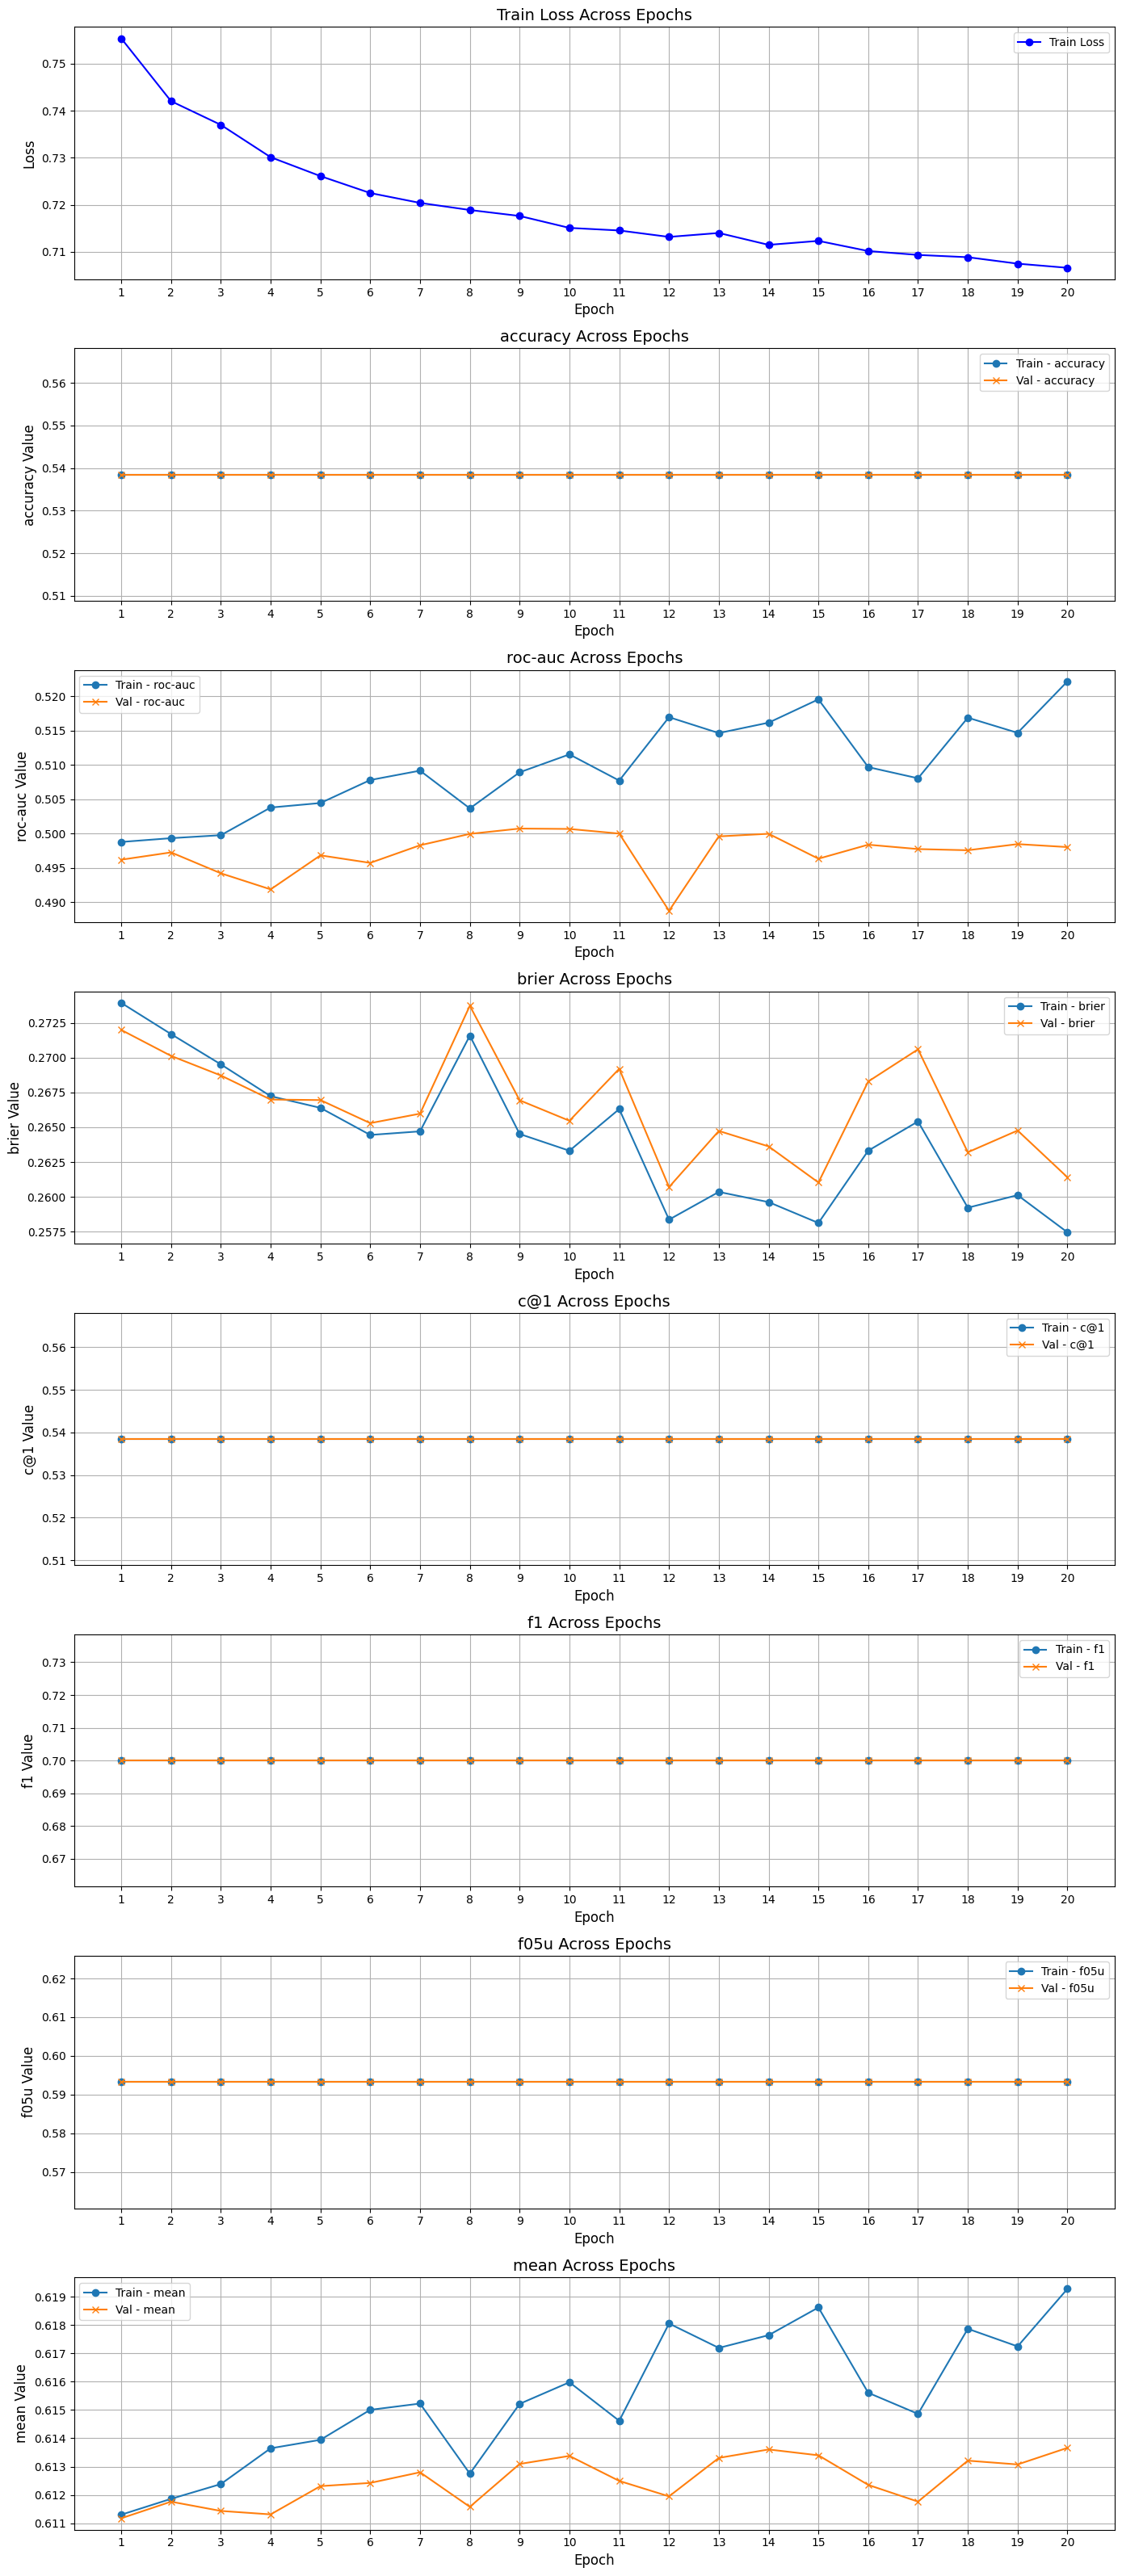

In [40]:
import matplotlib.pyplot as plt

metric_names = history["val_metrics"][0].keys()
epochs = list(range(1, len(history["val_metrics"]) + 1))

train_values = {name: [epoch.get(name, None) for epoch in history["train_metrics"]] for name in metric_names}
val_values = {name: [epoch.get(name, None) for epoch in history["val_metrics"]] for name in metric_names}

num_subplots = len(metric_names) + 1  # Number of metrics + train loss
plt.figure(figsize=(14, 4 * num_subplots))  # Increase height proportional to the number of plots

# Plot train loss
plt.subplot(num_subplots, 1, 1)

plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o", color="blue")
plt.title("Train Loss Across Epochs", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.xticks(epochs)
plt.grid(True)
plt.legend()

# Plotting each metric in a separate graph
for idx, metric in enumerate(metric_names):
    plt.subplot(len(metric_names) + 1, 1, idx + 2)  # Adjust index for additional loss plot
    plt.plot(epochs, train_values[metric], label=f'Train - {metric}', marker='o')
    plt.plot(epochs, val_values[metric], label=f'Val - {metric}', marker='x')
    plt.title(f"{metric} Across Epochs", fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel(f"{metric} Value", fontsize=12)
    plt.xticks(epochs)
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

## Evaluate test

In [41]:
# # Load the model from the saved checkpoint
# checkpoint_path = f"models/models_siames_bert_capa_no_congelada/fine_tuned_model_10_epochs_3e-05_lr_1_layers_256_batch_size_checkoint_6.pth"
# model = torch.load(checkpoint_path)
# model.to(device)

In [42]:
# Evaluación final en el conjunto de prueba
test_metrics = evaluate(model, test_loader, device)

print("Test Metrics:")
for metric_name, value in test_metrics.items():
    print(f"  {metric_name}: {value:.8f}")

Test Metrics:
  accuracy: 0.53846154
  roc-auc: 0.50742873
  brier: 0.26091870
  c@1: 0.53846154
  f1: 0.70000000
  f05u: 0.59322034
  mean: 0.61563838
